# Causal Analysis of Symmetric Facts (Exploratory)
We analyze where facts might be locateed in an LLM. A fact is represented by a tuple of subject, relation, object (s,r,o). We also investigate where an inverse fact mis located. An inverse fact is represented by the tuple (o, r^-1, s). For example, the fact "Paris is the capital of France" has the inverse fact "France's capital is France". 

## Setup

In [1]:
try:
    import google.colab
    IN_COLAB = True
    # %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
    renderer = "colab"
except:
    IN_COLAB = False
    from IPython import get_ipython
    %load_ext autoreload
    %autoreload 2
    renderer = "jupyterlab"

In [2]:
%%bash
cd ../
pip install poetry
poetry install
cd notebooks

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 2.8 MB/s eta 0:00:00
  Using cached importlib_metadata-6.7.0-py3-none-any.whl (22 kB)
  Using cached platformdirs-3.10.0-py3-none-any.whl (17 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.8.0
    Uninstalling platformdirs-3.8.0:
      Successfully uninstalled platformdirs-3.8.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.2.0
    Uninstalling importlib-metadata-5.2.0:
      Successfully uninstalled importlib-metadata-5.2.0
Installing dependencies from lock file

Package operations: 0 installs, 3 updates, 0 removals

  • Updating importlib-metadata (6.7.0 -> 5.2.0)
  • Updating urllib3 (1.26.16 -> 2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
circuitsvis 1.40.0 requires importlib-metadata<6.0.0,>=5.1.0, but you have importlib-metadata 6.7.0 which is incompatible.
sagemaker 2.167.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 6.7.0 which is incompatible.
sagemaker 2.167.0 requires protobuf<4.0,>=3.1, but you have protobuf 4.23.3 which is incompatible.


In [3]:

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = renderer

In [4]:
# Import stuff
import types
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [5]:
import ast
import pandas as pd

In [6]:
if IN_COLAB: 
    import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens.utilities import devices
from transformer_lens.past_key_value_caching import HookedTransformerKeyValueCache
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [7]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [8]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def cuda():
    return torch.cuda.is_available()

def get_device(): 
    return "cuda" if cuda() else "cpu"
device = get_device()
device


'cuda'

## Model

- fold_ln: Whether to fold in the LayerNorm weights to the subsequent linear layer. This does not change the computation.
- center_writing_weights: Whether to center weights writing to the residual stream (ie set mean to be zero). Due to LayerNormthis doesn't change the computation.
- center_unembed : Whether to center W_U (ie set mean to be zero). Softmax is translation invariant so this doesn't affect log probs or loss, but does change logits. Defaults to True.
- refactor_factored_attn_matrices: Whether to convert the factoredmatrices (W_Q & W_K, and W_O & W_V) to be "even". 

In [9]:
MODEL_NAME = "gpt2-large"

In [10]:
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    center_unembed=True,  
    center_writing_weights=True,              # Whether to center weights writing to the residual stream (ie set mean to be zero). Due to LayerNorm this doesn't change the computation.      
    fold_ln=True,                             # Whether to  fold in the LayerNorm weights to the subsequent linear layer.
    refactor_factored_attn_matrices=True,
)


 

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


## Dataset
We start with a small dataset of 12 prompts generated by ChatGPT and verified. TODO: add more samples. 
each sample, seen below, has a fact sentence_1 and its inverse fact sentence_2. It also has a set of counterfactual answers. 

In [11]:
path = "data/bijective_facts.csv"
df = pd.read_csv(path)
dataset = df.to_dict(orient="records")
for prompt in dataset: 
    prompt['counterfactuals'] = ast.literal_eval(prompt['counterfactuals'])
    prompt['inv_counterfactuals'] = ast.literal_eval(prompt['inv_counterfactuals'])


## Method2: Causal Tracing using Activation Patching


The setup of activation patching is to take two runs of the model on two different inputs, the clean run and the corrupted run. The clean run outputs the correct answer and the corrupted run does not. The key idea is that we give the model the corrupted input, but then **intervene** on a specific activation and **patch** in the corresponding activation from the clean run (ie replace the corrupted activation with the clean activation), and then continue the run. And we then measure how much the output has updated towards the correct answer.

We can then iterate over many possible activations and look at how much they affect the corrupted run. If patching in an activation significantly increases the probability of the correct answer, this allows us to *localise* which activations matter.

In [12]:
def pad_tokens_from_left(token_list : List[torch.tensor], maxlen:int):
    pad_token = model.tokenizer.pad_token_id
    padded_tokenized_inputs = torch.zeros((len(token_list), maxlen))
    for i, tokens in enumerate(token_list):
        n_pads = maxlen - tokens.shape[-1]
        padded_tokenized_inputs[i, :n_pads] = pad_token
        padded_tokenized_inputs[i, n_pads:] = tokens
    return padded_tokenized_inputs.long()

def get_corrupted_prompts(dataset, 
                         forward=False, 
                         noise_multiplier=8, 
                         sample_idx=None):
    if sample_idx is not None: 
        dataset = [d for i,d in enumerate(dataset) if i in sample_idx]
        
    if forward: 
        subject = "subject"
        obj = "obj"
        sentence = "fact"
    else:
        subject = "obj"
        obj = "subject"
        sentence = "inv_fact"

    noise_scale = model.W_E.std(dim=-1).mean(dim=-1) * noise_multiplier
    d_model = model.W_E.shape[-1]
        
    prompts = []

    for i, sample in enumerate(dataset): 
        
        subject_tokens = model.to_tokens(sample[subject])
        n_tokens = subject_tokens.shape[-1]
    
        noise = torch.randn(n_tokens, d_model).to(device)*noise_scale
        noise_mask = torch.ones(n_tokens, d_model).to(device)
        noise_mask[0,:] = 0 #dont noisify start token (shape: tokens, d_model)
        
        noise = torch.mul(noise, noise_mask.float())
        embeddings = model.embed(subject_tokens) #[batch] x [n_tokens] x [residual_dim]
        embeddings = embeddings + noise
                     
        logits = model.unembed(embeddings)  #[batch] x [n_tokens] x [vocab_size]
        noisy_tokens = torch.argmax(logits, dim=-1) #[batch] x [n_tokens]+

        #making sure there are no more end of sequence tokens in the middle of the prompt
        mask = (noisy_tokens == 50256).to(device)
        mask[:,0] = 0
        random_integers = torch.randint(0, 50256 - 1, noisy_tokens.size(), dtype=torch.long).to(device)
        noisy_tokens = torch.where(mask, random_integers, noisy_tokens)
        noisy_token_str = model.to_string(noisy_tokens[:,1:])
        
        corrupted_prompts = sample[sentence].format(subject=noisy_token_str[0], obj="")[:-1]
        prompts.append(corrupted_prompts)
    
    return prompts



In [13]:
forward_corrupted_prompts = get_corrupted_prompts(dataset,
                                               forward = True,
                                               noise_multiplier = 25, 
                                               sample_idx=None)

forward_corrupted_prompts

['eanor is the capital of',
 ' Stall Output is the capital of',
 "thelesssets's capital is",
 ' asc Trick live in the',
 ' enclhots live in the',
 ' Hornetsces live in the',
 ' Suc Shal is the founder of',
 ' Thatcher Chronicle is the founder of',
 'adiumouston is the founder of',
 'The  Chicitely is the longest river in',
 'The stocks Iokens is the longest river in',
 ' heck is the language spoken in',
 'fore is the language spoken in',
 'verbs is the language spoken in']

In [14]:
backward_corrupted_prompts = get_corrupted_prompts(dataset,
                                               forward = False,
                                               noise_multiplier = 25, 
                                               sample_idx=None)

backward_corrupted_prompts

["QL's capital is",
 "SPONSORED's capital is",
 'The capital of rentice is',
 'The walletbered is the habitat of',
 'The cell resil is the habitat of',
 'The Dur galvan is the habitat of',
 'efe was founded by',
 'gra was founded by',
 'ourn was founded by',
 " Sabhaalin's longest river is the",
 " Colomb's longest river is the",
 "iments's people speak",
 "iola's people speak",
 "coin's people speak"]

In [29]:
def get_logit_difference_from_token_prompt(prompt_tokens_list,
                         correct_answer,
                         counterfactual_answers,
                         per_prompt=False, 
                         disp=True):
    differences = []
    for prompt_tokens, correct, counterfactuals in zip(prompt_tokens_list, correct_answer, counterfactual_answers):
        logits, _ = model.run_with_cache(prompt_tokens) #logits shape : prompts x tokens x vocab_size
        final_logits = logits[:,-1,:]
        correct_answer_token = model.to_tokens(correct)[:,-1].unsqueeze(-1)
        counter_answer_tokens = model.to_tokens(counterfactuals)[:,-1].unsqueeze(-1) #pass all counterfactuals
        correct_answer_logits = final_logits.gather(dim=-1, index=correct_answer_token)
        counter_factual_logits = final_logits.gather(dim=-1, index=counter_answer_tokens.transpose(1,0))
        diffs = correct_answer_logits - counter_factual_logits
        differences.append(diffs)
    differences = torch.vstack(differences)
    if disp: 
        print("Prompt logit differences", differences)
        print(f"Average logit difference (probability {torch.exp(avg):.2f}x of correct over counter): {avg.item():.2f}")
    if per_prompt:
        #list of tensors (tensor : n_counterfact x d_model)
        return differences
    else:
        avg = torch.mean(differences)
        return avg

def normalize_patched_logit_diff(patched_logit_diff, corrupted_average_logit_diff,original_average_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff)/(original_average_logit_diff - corrupted_average_logit_diff)

def logits_to_ave_logit_diff(prompt_logits : torch.Tensor,
                             correct_answer : str,
                             incorrect_answer : str):
    final_logits = prompt_logits[:,-1,:] #shape 1 x vocab_size
    #tokenize the correct answer and the counterfactual
    #we remove the first token as it is an end of sequenc token
    correct_answer_token = model.to_tokens(correct_answer)[:,1:] #1x1
    incorrect_answer_token = model.to_tokens(incorrect_answer)[:,1:] #1xn_counterfacts
    
    correct_answer_logits = final_logits[:,correct_answer_token]
    counter_factual_logits = final_logits[:, incorrect_answer_token]
    
    #correct_answer or counterfact answer is tokenized 
    #correct_answer_logits: 1,1,tokens where tokens 
    #counter_factual_logits: 1,n_counterfacts,tokens_max padded in case n_token<token_max
    
    #how to deal with this ???????
    #so far it works... we normalize
    diff = correct_answer_logits - counter_factual_logits
    return diff.squeeze(dim=-1) #difference wrt all counterfacts

def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    """
    Restore a patch in clean run. 
    """
    return corrupted_residual_component


def causal_tracing(clean_prompts: List[str], corrupted_prompts: List[str], correct_answers: List[str], counterfactual_answers: List[List[str]], forward=False, sample_idx=None):    
    if sample_idx is not None: 
        clean_prompts = [c for i,c in enumerate(clean_prompts) if i in sample_idx]
        corrupted_prompts = [c for i,c in enumerate(corrupted_prompts) if i in sample_idx]
        correct_answers = [c for i,c in enumerate(correct_answers) if i in sample_idx]
        counterfactual_answers = [c for i,c in enumerate(counterfactual_answers) if i in sample_idx]
    
    # patched_residual_stream_diff = torch.zeros(model.cfg.n_layers, padded_original_prompt_tokens.shape[1], device="cpu", dtype=torch.float32)
    patches = []
    for i in range(len(clean_prompts)): 
        clean_prompt = clean_prompts[i]
        corrupted_prompt = corrupted_prompts[i]
        correct_answer = correct_answers[i]
        counterfactuals = counterfactual_answers[i]
        
        clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True) 
        corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=True)

        clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
                
        #we run the model getting the logit outputs for both clean and corrupted prompts
        #logits shape: [1, n_tokens, vocab_size]
        clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
        corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
        
        #shape = (1, n_counterfactuals)
        #for each prompt, we get logit difference of generating the correct answer vs each counterfactual (for clean and corrupted subjects)
        # clean_logit_diffs = get_logit_difference_from_token_prompt([clean_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        # corrupted_logit_diffs = get_logit_difference_from_token_prompt([corrupted_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        clean_logit_diffs = logits_to_ave_logit_diff(clean_logits, correct_answer, counterfactuals)
        corrupted_logit_diffs = logits_to_ave_logit_diff(corrupted_logits, correct_answer, counterfactuals)
        
        if clean_tokens.shape[-1] != corrupted_tokens.shape[-1]:
            raise ValueError(f"different number of tokens on prompt {i}")
            
        patched_residual_stream_diff = torch.zeros(model.cfg.n_layers, clean_tokens.shape[-1], device=device, dtype=torch.float32)
        for layer in range(model.cfg.n_layers):
            for position in range(clean_tokens.shape[1]):
        
                hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
                #here we patch in the activations in the residual stream at token position and layer. 
                patched_logits = model.run_with_hooks(
                                                    corrupted_tokens,
                                                    fwd_hooks = [(utils.get_act_name("resid_pre", layer),hook_fn)],
                                                    return_type="logits"
                )
                #we return the logits after having restored the activation in residual stream of position,layer
                
                #calculate the logit differences wrt counterfactuals after patching (shape : counter_fact x logit_dim x max_counterfact_tokens)
                all_patched_logit_diff = logits_to_ave_logit_diff(patched_logits, correct_answer, counterfactuals)
                #each of the tensors are shape (1 x n_counterfact (delta logit on output token)
                
                #this normalization is done element wise. so if a word is tokenized into two tokens, normalization is done by token
                normalized_patched_logit_diffs = normalize_patched_logit_diff(
                                                                            all_patched_logit_diff,
                                                                             corrupted_logit_diffs,
                                                                             clean_logit_diffs
                                                                        )
                #since the logit of the second token 
                mean_normalized_patched_logit_diffs = torch.mean(normalized_patched_logit_diffs, dim=(0,1)) #mean over counterfactuals (leave token_dim alone)
                #now we have 
                
                patched_residual_stream_diff[layer, position] = mean_normalized_patched_logit_diffs #mean over counterfactuals
                
        patches.append(patched_residual_stream_diff)
    return patches
        
        
def pad_from_left(tokens : torch.tensor, maxlen:int):
    pad_token = model.tokenizer.pad_token_id
    padded_tokenized_inputs = torch.zeros(tokens.shape[0], maxlen)
    
    n_pads = maxlen - tokens.shape[-1]
    padded_tokenized_inputs[:,n_pads] = pad_token
    padded_tokenized_inputs[:,n_pads:] = tokens
    return padded_tokenized_inputs.long()

def pad_to_same_length(clean_tokens, corrupted_tokens): 
    
    maxlen = max([clean_tokens.shape[-1], corrupted_tokens.shape[-1]])
    
    if clean_tokens.shape[-1] > corrupted_tokens.shape[-1]: 
        corrupted_tokens = pad_from_left(corrupted_tokens, maxlen)
    elif clean_tokens.shape[-1] < corrupted_tokens.shape[-1]: 
        clean_tokens = pad_from_left(clean_tokens, maxlen)
    return clean_tokens, corrupted_tokens

In [28]:
forward_clean_prompts = [
    d["fact"].format(subject=d["subject"], obj="")[:-1] for d in dataset
]
forward_correct_answers = [d["obj"] for d in dataset]
forward_counters = [d["counterfactuals"] for d in dataset]



forward_patches = causal_tracing(clean_prompts=forward_clean_prompts,
                               corrupted_prompts=forward_corrupted_prompts,
                               correct_answers=forward_correct_answers,
                               counterfactual_answers=forward_counters,
                               forward=False, 
                               sample_idx=[0])

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [30]:
backward_clean_prompts = [
    d["inv_fact"].format(subject=d["obj"], obj="")[:-1] for d in dataset
]
backward_correct_answers = [d["subject"] for d in dataset]
backward_counters = [d["inv_counterfactuals"] for d in dataset]

backward_patches = causal_tracing(clean_prompts=backward_clean_prompts,
               corrupted_prompts=backward_corrupted_prompts,
               correct_answers=backward_correct_answers,
               counterfactual_answers=backward_counters, 
               sample_idx=[0])

3
3
3
--------


RuntimeError: expand(torch.cuda.FloatTensor{[2]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)

In [ ]:

for i,(forward_patch, backward_patch) in enumerate(zip(forward_patches, backward_patches)): 
    prompt = forward_clean_prompts[i]
    print(prompt)
    x = model.to_str_tokens(prompt)
    while len(x) < forward_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(forward_patch,
           x=x,
           title="Logit Difference From Patched Residual Stream", labels={"x":"Position", "y":"Layer"})
    
    prompt = backward_clean_prompts[i]
    print(prompt)
    x = model.to_str_tokens(prompt)
    while len(x) < backward_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(backward_patch,
           x=x,
           title="Logit Difference From Patched Residual Stream", labels={"x":"Position", "y":"Layer"})

## Causal trace on Layers

In [467]:
def causal_tracing_on_layers(clean_prompts: List[str], corrupted_prompts: List[str], correct_answers: List[str], counterfactual_answers: List[List[str]], sample_idx=None):    
    if sample_idx is not None: 
        clean_prompts = [c for i,c in enumerate(clean_prompts) if i in sample_idx]
        corrupted_prompts = [c for i,c in enumerate(corrupted_prompts) if i in sample_idx]
        correct_answers = [c for i,c in enumerate(correct_answers) if i in sample_idx]
        counterfactual_answers = [c for i,c in enumerate(counterfactual_answers) if i in sample_idx]
    
    # patched_residual_stream_diff = torch.zeros(model.cfg.n_layers, padded_original_prompt_tokens.shape[1], device="cpu", dtype=torch.float32)
    attn_patches = []
    mlp_patches = []
    for i in range(len(clean_prompts)): 
        clean_prompt = clean_prompts[i]
        corrupted_prompt = corrupted_prompts[i]
        correct_answer = correct_answers[i]
        counterfactuals = counterfactual_answers[i]
        
        clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True)
        corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=True)
        
        clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
        
        clean_logit_diffs = get_logit_difference_from_token_prompt([clean_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        corrupted_logit_diffs = get_logit_difference_from_token_prompt([corrupted_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        
        clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
        corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
        
        
        if clean_tokens.shape[-1] != corrupted_tokens.shape[-1]:
            raise ValueError(f"different number of tokens on prompt {i}")
            
        patched_attn_diff = torch.zeros(model.cfg.n_layers, clean_tokens.shape[-1], device=device, dtype=torch.float32)
        patched_mlp_diff = torch.zeros(model.cfg.n_layers, clean_tokens.shape[-1], device=device, dtype=torch.float32)
        
        for layer in range(model.cfg.n_layers):
            for position in range(clean_tokens.shape[-1]):

                hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
                patched_attn_logits = model.run_with_hooks(
                    corrupted_tokens,
                    fwd_hooks = [(utils.get_act_name("attn_out", layer),
                        hook_fn)],
                    return_type="logits"
                )
                patched_attn_logit_diff = logits_to_ave_logit_diff(patched_attn_logits, correct_answer, counterfactuals)
                
                patched_mlp_logits = model.run_with_hooks(
                    corrupted_tokens,
                    fwd_hooks = [(utils.get_act_name("mlp_out", layer),
                        hook_fn)],
                    return_type="logits"
                )
                patched_mlp_logit_diff = logits_to_ave_logit_diff(patched_mlp_logits, correct_answer, counterfactuals)

                patched_attn_diff[layer, position] = normalize_patched_logit_diff(
                                                                                patched_attn_logit_diff,
                                                                                torch.mean(corrupted_logit_diffs),
                                                                                torch.mean(clean_logit_diffs)
                                                                                 )
                patched_mlp_diff[layer, position] = normalize_patched_logit_diff(patched_mlp_logit_diff,
                                                                                 torch.mean(corrupted_logit_diffs),
                                                                                torch.mean(clean_logit_diffs)
                                                                                 )
            
     
        attn_patches.append(patched_attn_diff)
        mlp_patches.append(patched_mlp_diff)
    return attn_patches, mlp_patches

In [468]:
forward_clean_prompts = [
    d["sentence_1"].format(subject=d["subject_1"], obj="")[:-1] for d in dataset
]
forward_correct_answers = [d["object_1"] for d in dataset]
forward_counters = [d["counter_factual_1"] for d in dataset]

forward_attn_patches, forward_mlp_patches = causal_tracing_on_layers(clean_prompts=forward_clean_prompts,
                                                       corrupted_prompts=forward_corrupted_prompts,
                                                       correct_answers=forward_correct_answers,
                                                       counterfactual_answers=forward_counters)


In [469]:
back_clean_prompts = [
    d["sentence_2"].format(subject=d["subject_2"], obj="")[:-1] for d in dataset
]
back_correct_answers = [d["object_2"] for d in dataset]
back_counters = [d["counter_factual_2"] for d in dataset]

back_attn_patches, back_mlp_patches = causal_tracing_on_layers(clean_prompts=back_clean_prompts,
                                                       corrupted_prompts=backward_corrupted_prompts,
                                                       correct_answers=back_correct_answers,
                                                       counterfactual_answers=back_counters)


Paris is the capital of


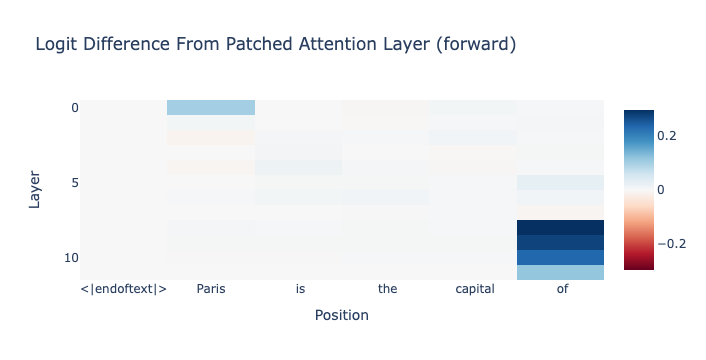

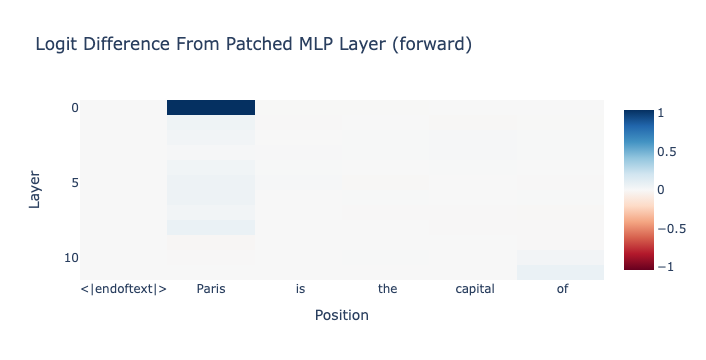

The capital of France is


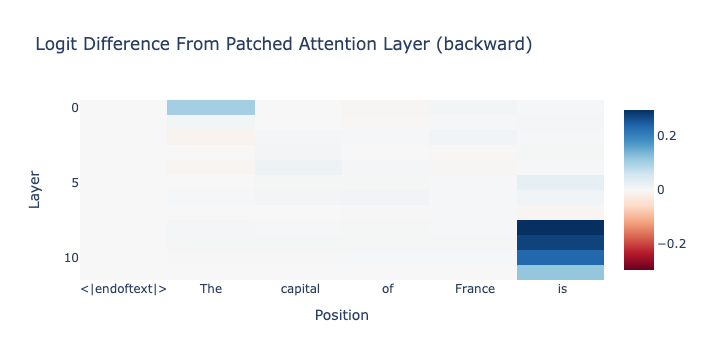

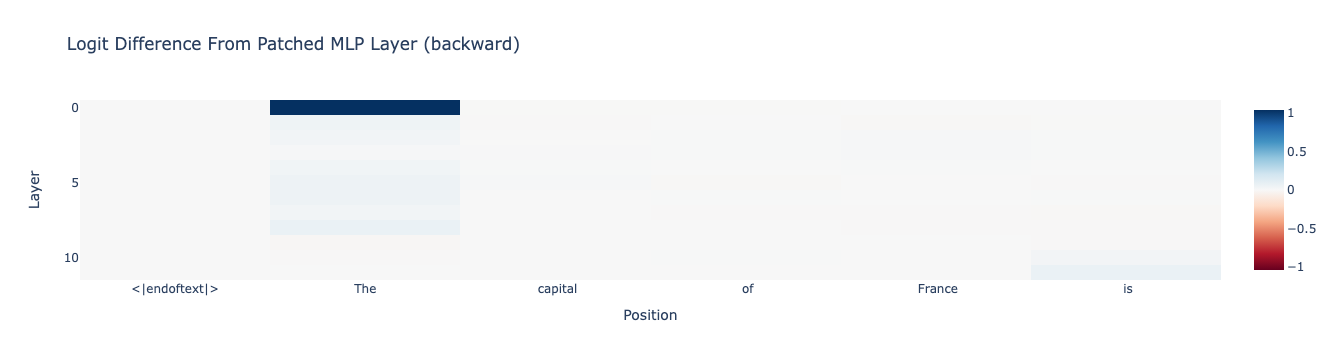

Rome is the capital of


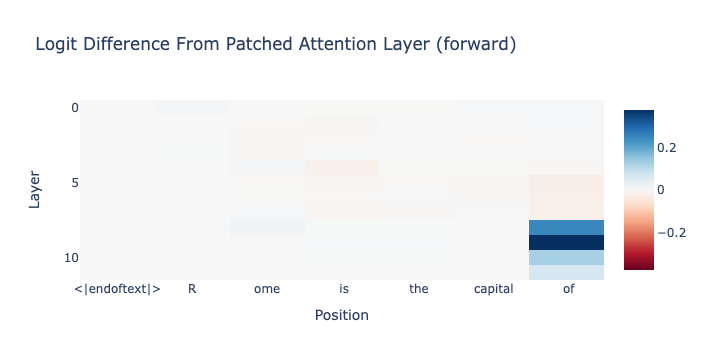

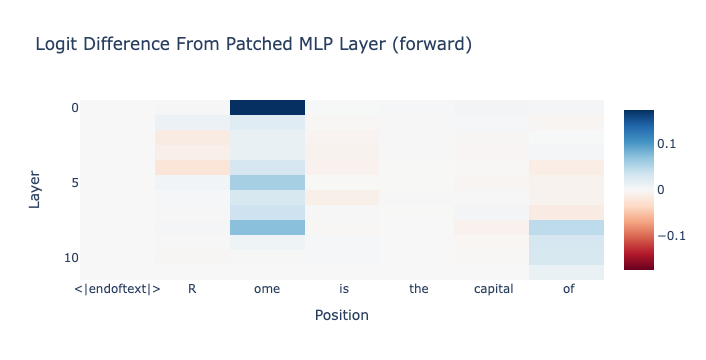

The capital of Italy is


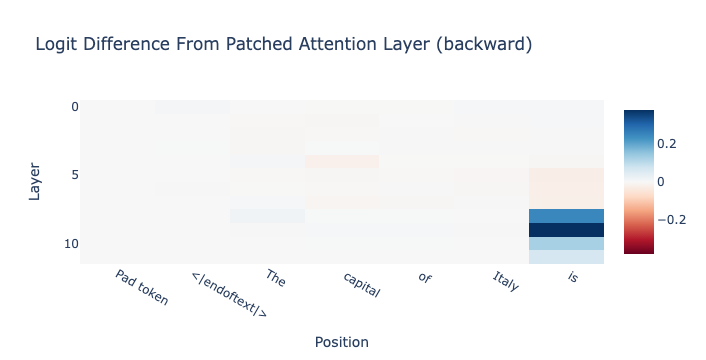

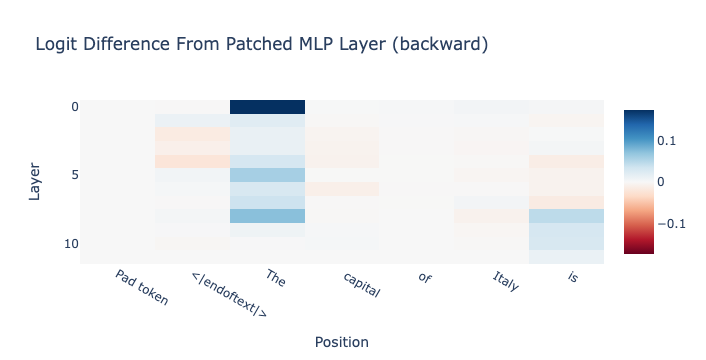

Ottawa is the capital of


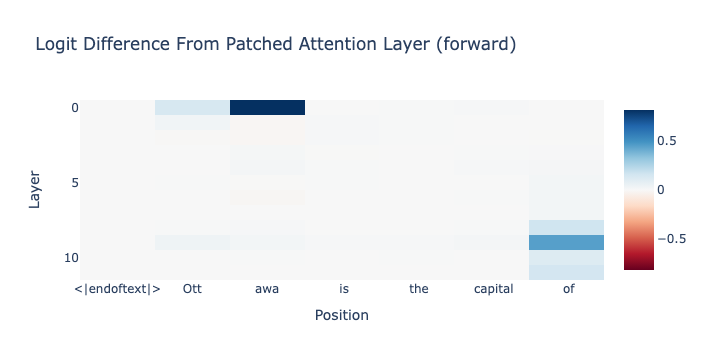

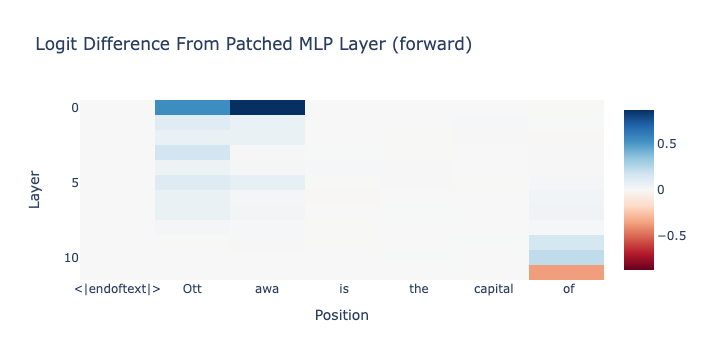

The capital of Canada is


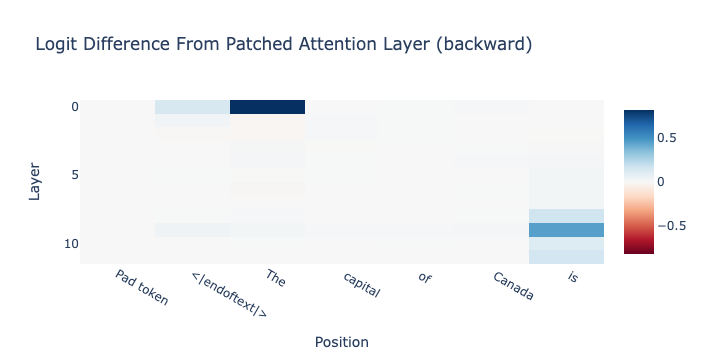

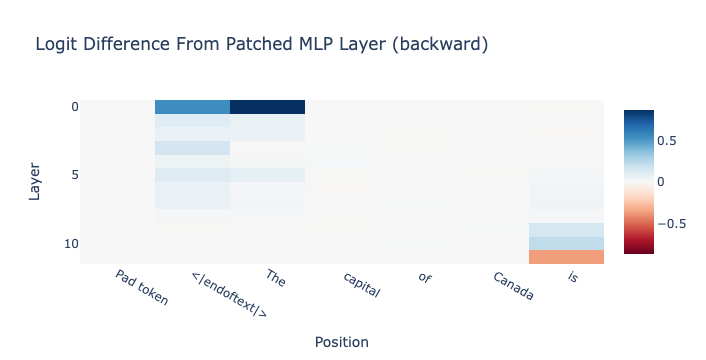

Dolphins live in the


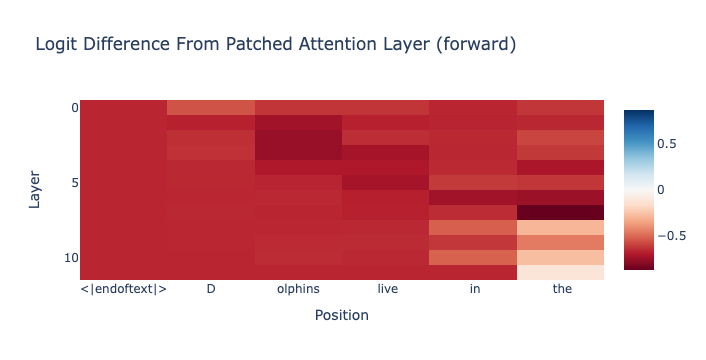

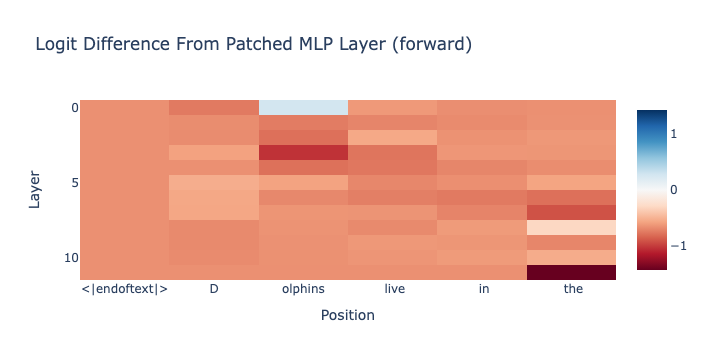

The ocean is home to


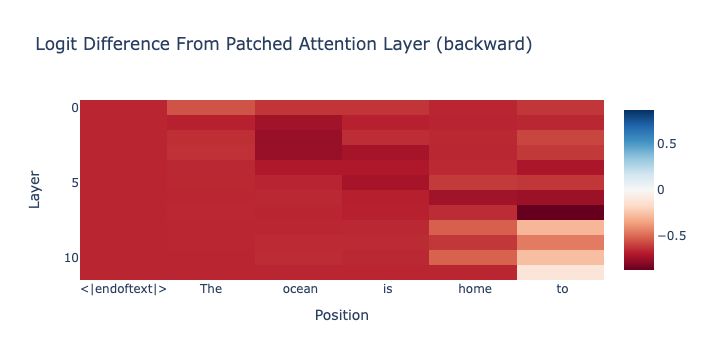

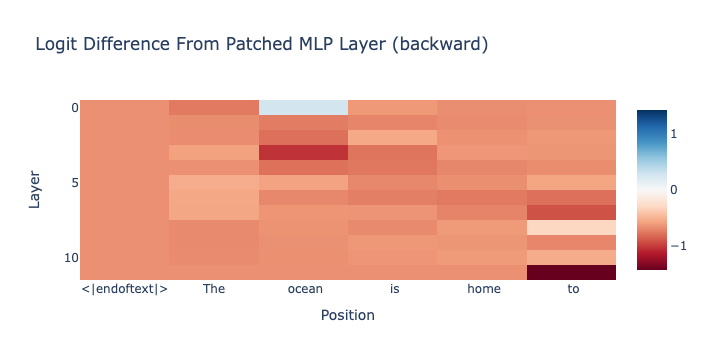

Tigers live in the


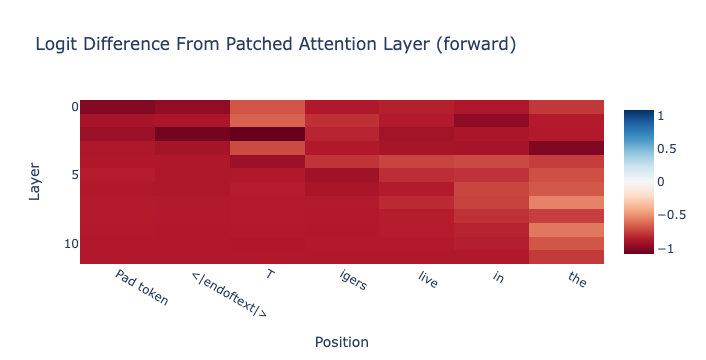

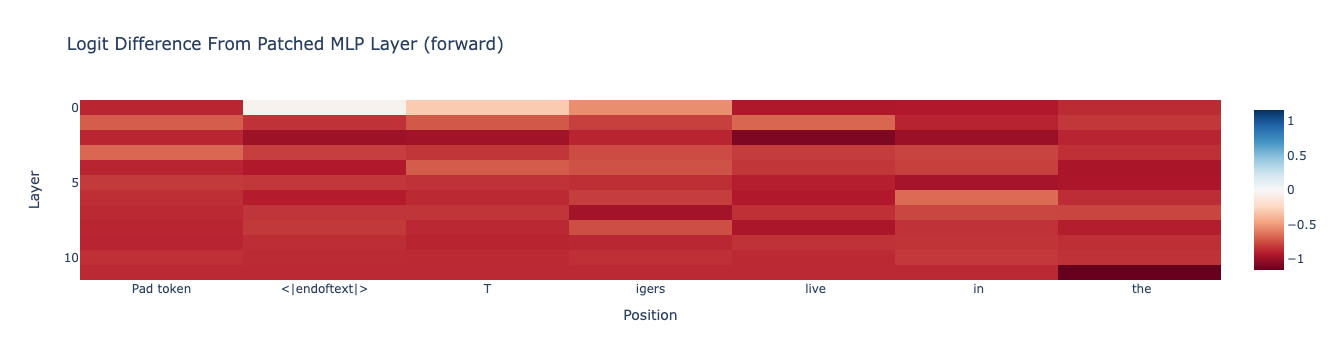

The jungle is home to


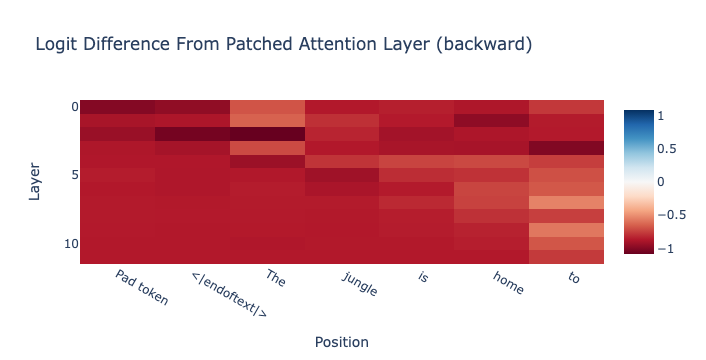

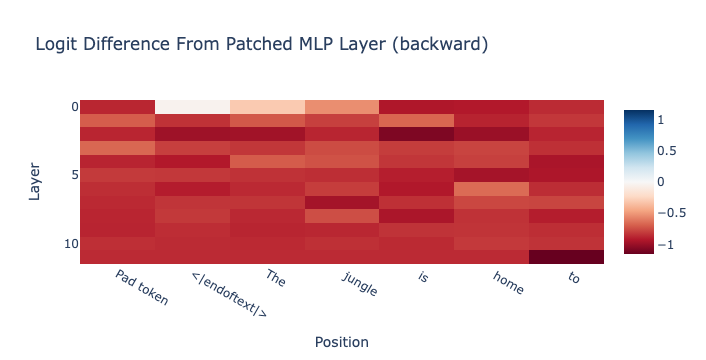

Camels live in the


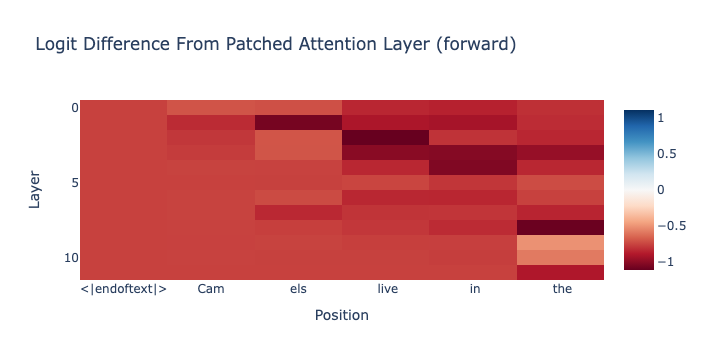

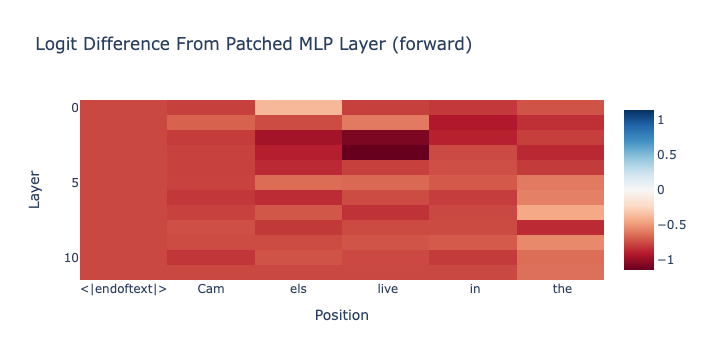

The desert is home to


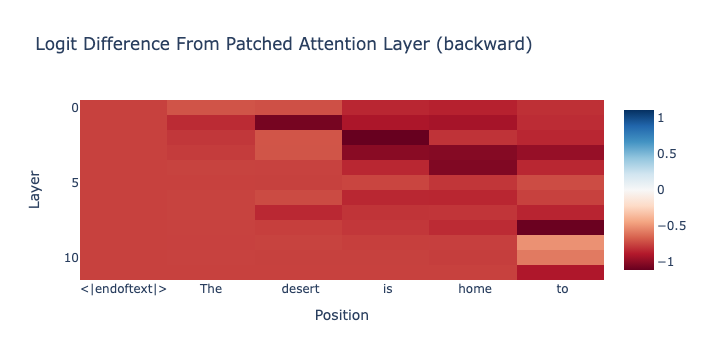

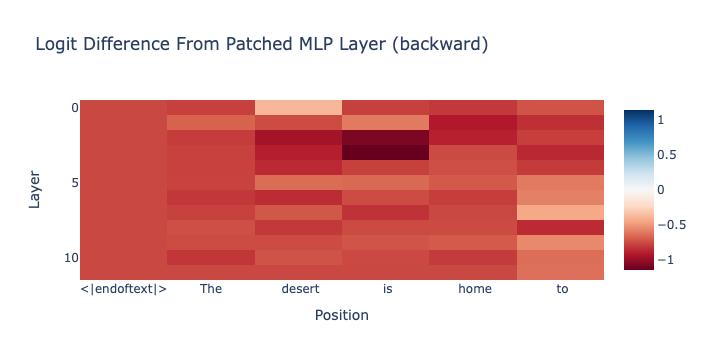

Bill Gates is the founder of


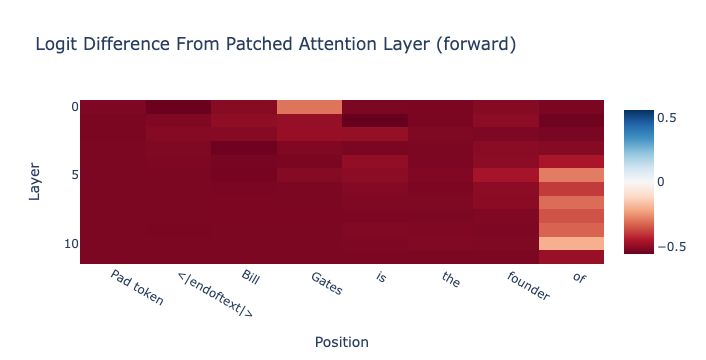

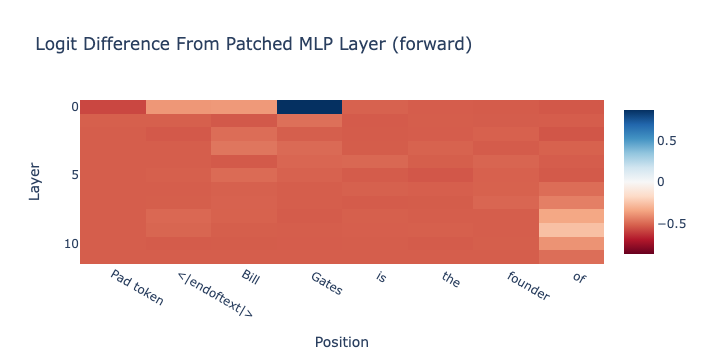

Microsoft was founded by


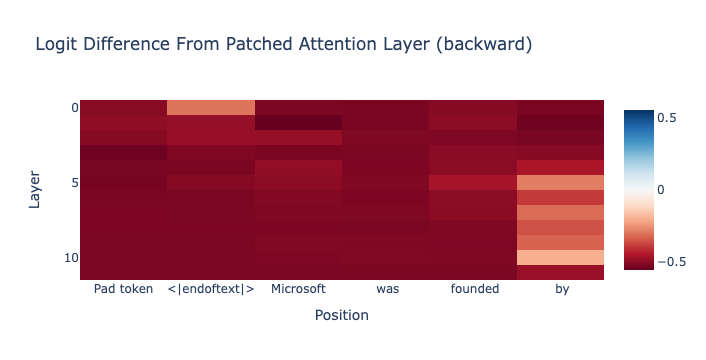

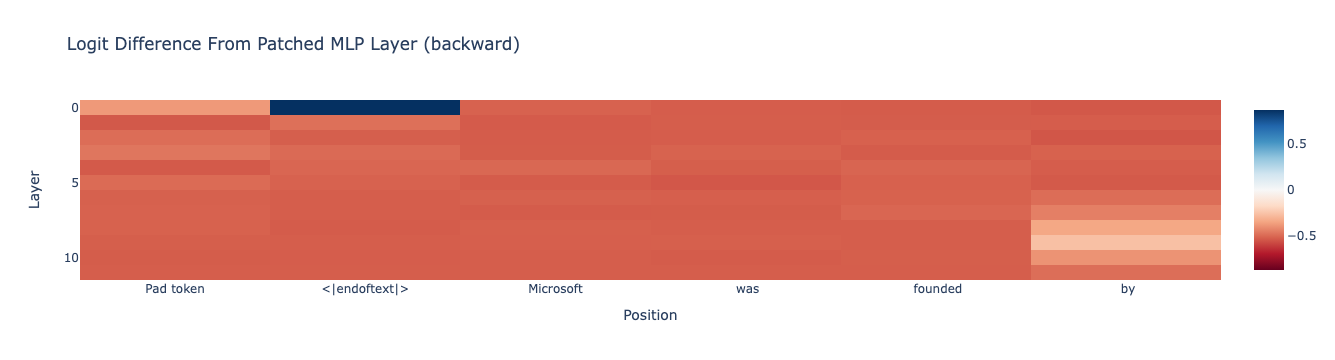

The Nile is the longest river in


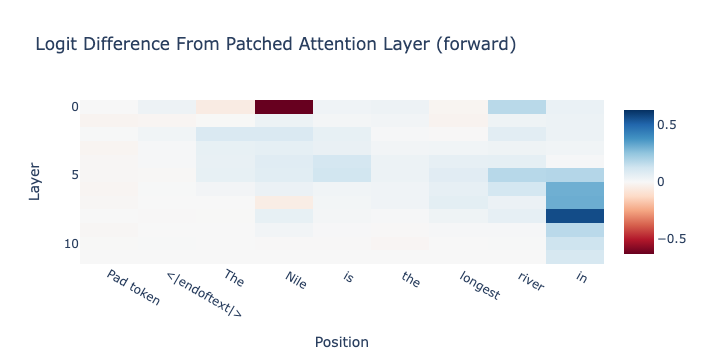

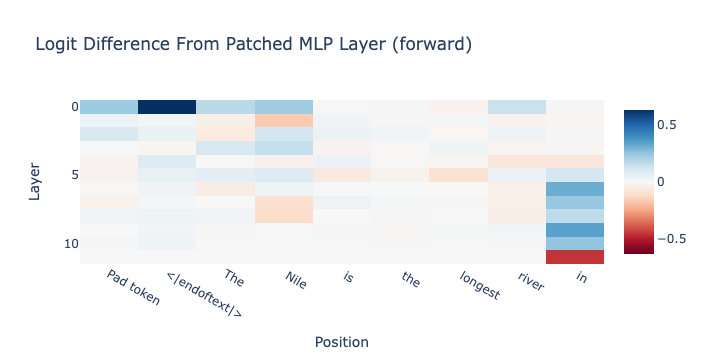

The longest river in Africa is the


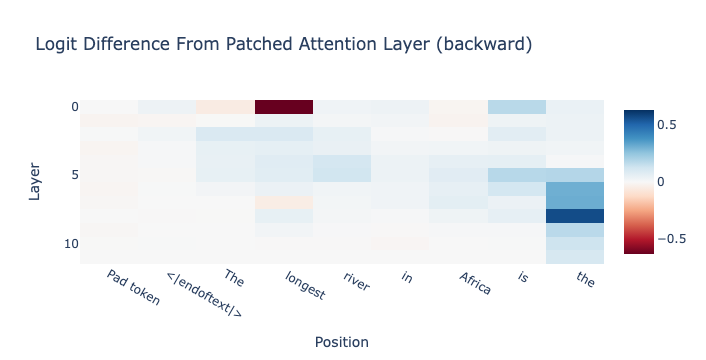

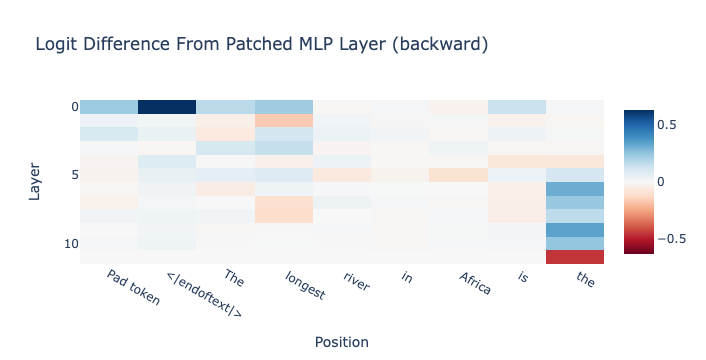

The Yangtze is the longest river in


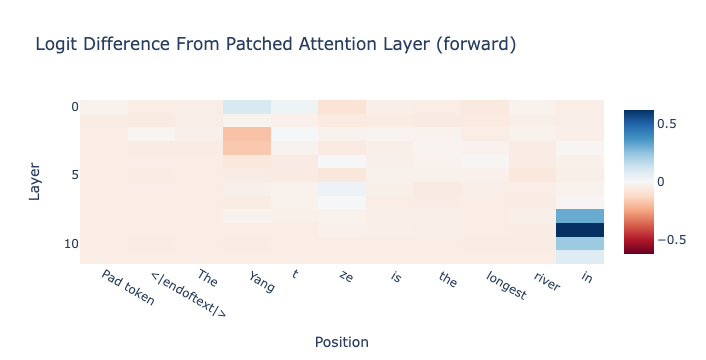

The longest river in Asia is the


English is the language spoken in


People from England speak


French is the language spoken in


People from France speak


German is the language spoken in


People from Germany speak


In [470]:
for i in range(len(forward_clean_prompts)): 
    forward_prompt = forward_clean_prompts[i]
    print(forward_prompt)
    attn_patch = forward_attn_patches[i]
    mlp_patch = forward_mlp_patches[i]
    
    x = model.to_str_tokens(forward_prompt)
    while len(x) < attn_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(attn_patch,
           x=x,
           title="Logit Difference From Patched Attention Layer (forward)", labels={"x":"Position", "y":"Layer"})

    x = model.to_str_tokens(forward_prompt)
    while len(x) < mlp_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(mlp_patch,
           x=x,
           title="Logit Difference From Patched MLP Layer (forward)", labels={"x":"Position", "y":"Layer"})
    
    backward_prompt = back_clean_prompts[i]
    print(backward_prompt)
    x = model.to_str_tokens(backward_prompt)
    while len(x) < attn_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(attn_patch,
           x=x,
           title="Logit Difference From Patched Attention Layer (backward)", labels={"x":"Position", "y":"Layer"})

    x = model.to_str_tokens(backward_prompt)
    while len(x) < mlp_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(mlp_patch,
           x=x,
           title="Logit Difference From Patched MLP Layer (backward)", labels={"x":"Position", "y":"Layer"})
    

## Causal Trace on Heads

In [463]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][:, :, head_index, :]
    return corrupted_head_vector


def causal_tracing_on_heads(clean_prompts: List[str], corrupted_prompts: List[str], correct_answers: List[str], counterfactual_answers: List[List[str]], sample_idx=None):    
    if sample_idx is not None: 
        clean_prompts = [c for i,c in enumerate(clean_prompts) if i in sample_idx]
        corrupted_prompts = [c for i,c in enumerate(corrupted_prompts) if i in sample_idx]
        correct_answers = [c for i,c in enumerate(correct_answers) if i in sample_idx]
        counterfactual_answers = [c for i,c in enumerate(counterfactual_answers) if i in sample_idx]
    
    # patched_residual_stream_diff = torch.zeros(model.cfg.n_layers, padded_original_prompt_tokens.shape[1], device="cpu", dtype=torch.float32)
    patches = []
    for i in range(len(clean_prompts)): 
        clean_prompt = clean_prompts[i]
        corrupted_prompt = corrupted_prompts[i]
        correct_answer = correct_answers[i]
        counterfactuals = counterfactual_answers[i]
        
        clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True)
        corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=True)
        
        clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
        
        clean_logit_diffs = get_logit_difference_from_token_prompt([clean_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        corrupted_logit_diffs = get_logit_difference_from_token_prompt([corrupted_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        
        clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
        corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
        
        
        if clean_tokens.shape[-1] != corrupted_tokens.shape[-1]:
            raise ValueError(f"different number of tokens on prompt {i}")
            
        patched_head_z_diff = torch.zeros(model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32)
        for layer in range(model.cfg.n_layers):
            for head_index in range(model.cfg.n_heads):
                hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=clean_cache)
                patched_logits = model.run_with_hooks(
                    corrupted_tokens,
                    fwd_hooks = [(utils.get_act_name("z", layer, "attn"),
                        hook_fn)],
                    return_type="logits"
                )
                patched_logit_diff = logits_to_ave_logit_diff(patched_logits, correct_answer, counterfactuals)
                patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(patched_logit_diff, torch.mean(corrupted_logit_diffs),torch.mean(clean_logit_diffs))
     
        patches.append(patched_head_z_diff)
    return patches

In [465]:
forward_clean_prompts = [
    d["sentence_1"].format(subject=d["subject_1"], obj="")[:-1] for d in dataset
]
forward_correct_answers = [d["object_1"] for d in dataset]
forward_counters = [d["counter_factual_1"] for d in dataset]

forward_patches = causal_tracing_on_heads(clean_prompts=forward_clean_prompts,
               corrupted_prompts=forward_corrupted_prompts,
               correct_answers=forward_correct_answers,
               counterfactual_answers=forward_counters)

backward_clean_prompts = [
    d["sentence_2"].format(subject=d["subject_2"], obj="")[:-1] for d in dataset
]
backward_correct_answers = [d["object_2"] for d in dataset]
backward_counters = [d["counter_factual_2"] for d in dataset]

backward_patches = causal_tracing_on_heads(clean_prompts=backward_clean_prompts,
               corrupted_prompts=backward_corrupted_prompts,
               correct_answers=backward_correct_answers,
               counterfactual_answers=backward_counters)

Paris is the capital of


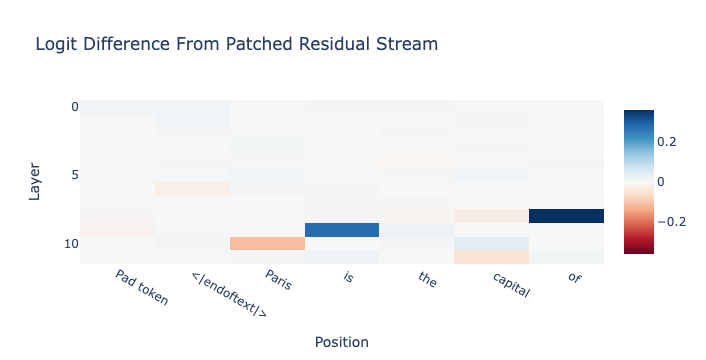

The capital of France is


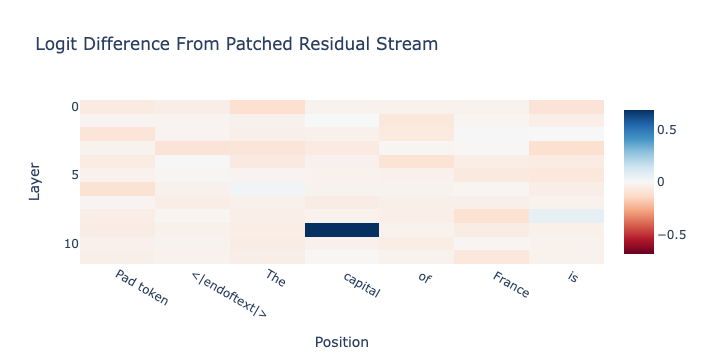

Rome is the capital of


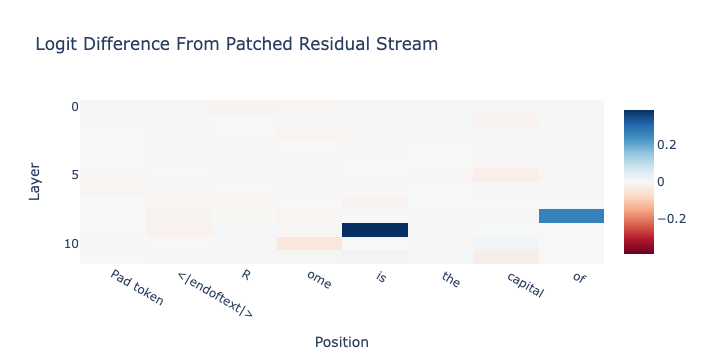

The capital of Italy is


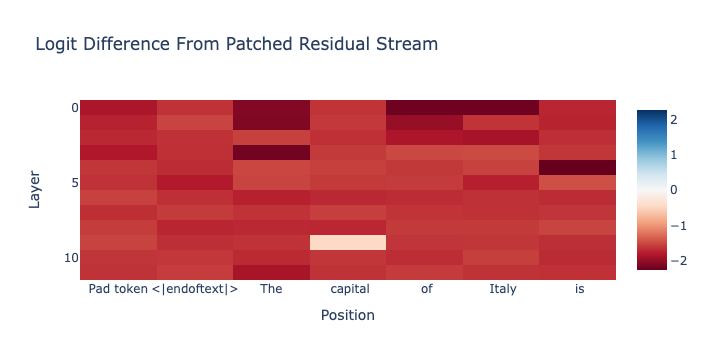

Ottawa is the capital of


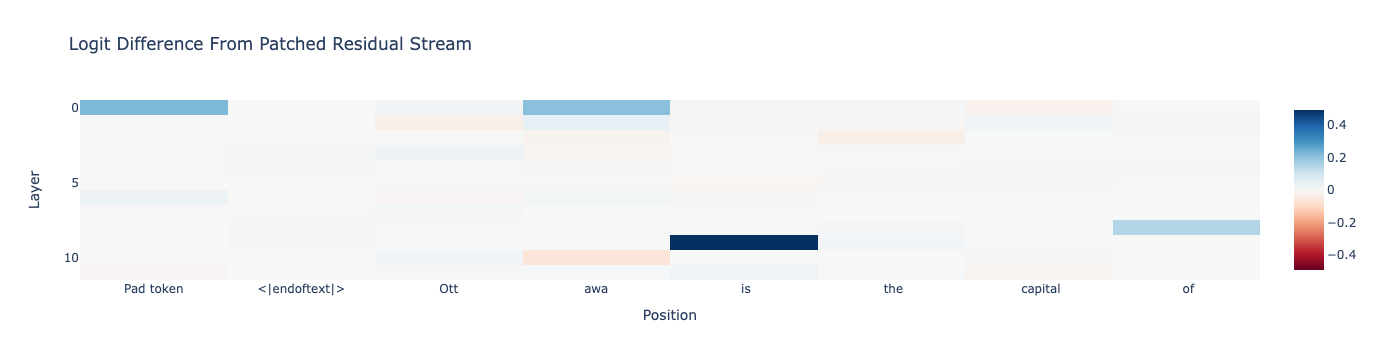

The capital of Canada is


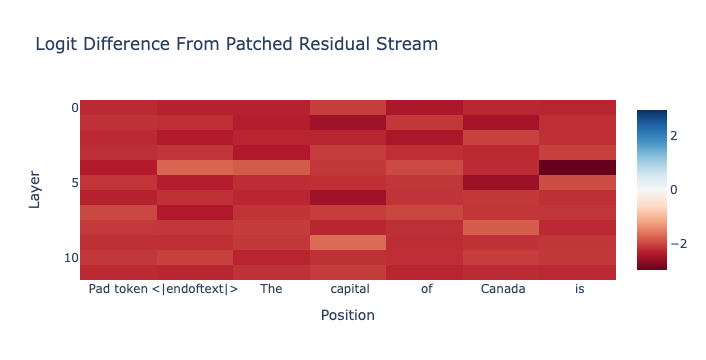

Dolphins live in the


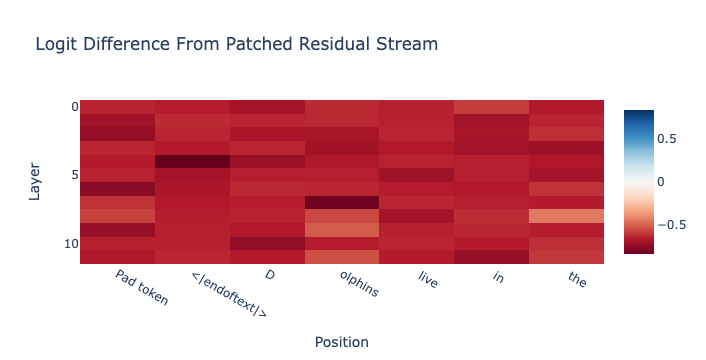

The ocean is home to


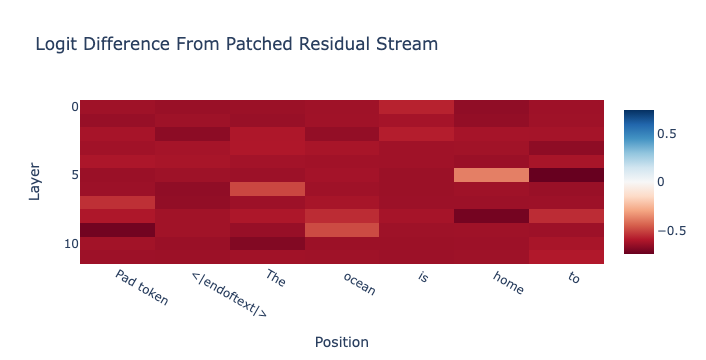

Tigers live in the


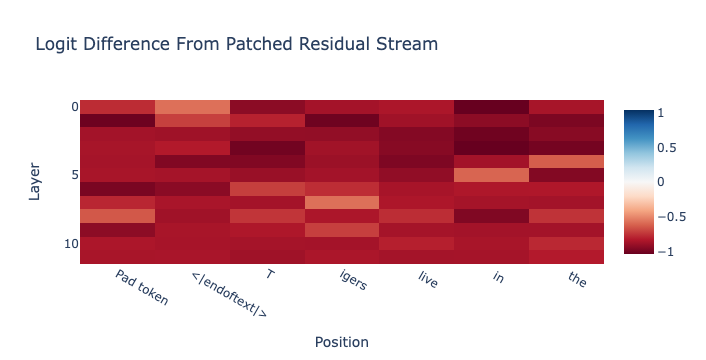

The jungle is home to


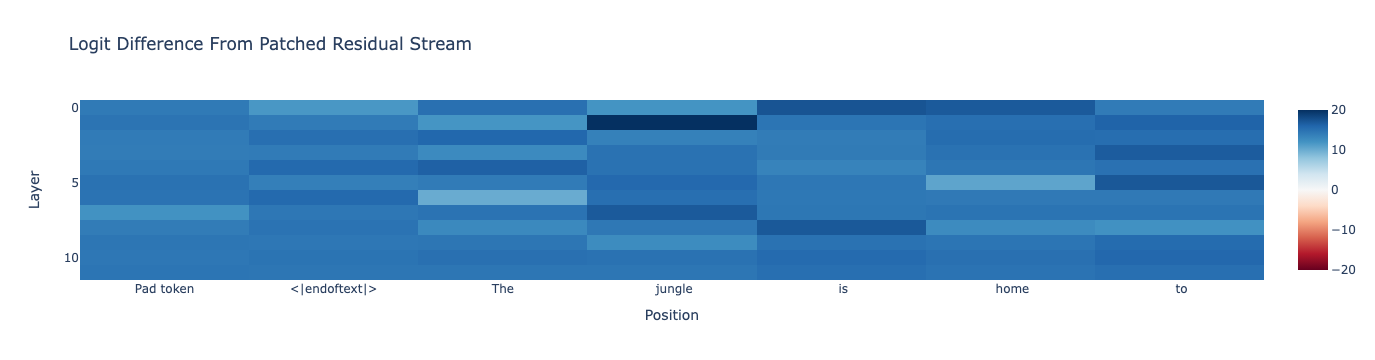

Camels live in the


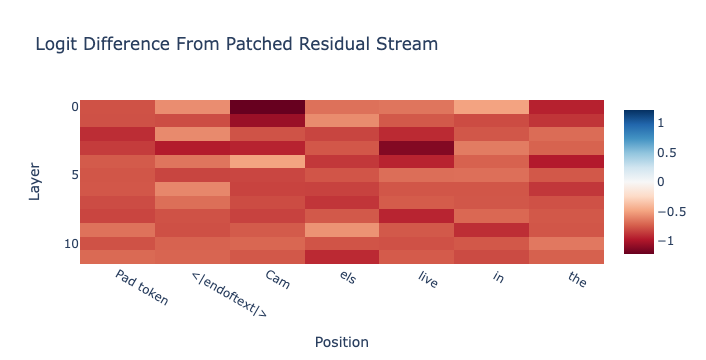

The desert is home to


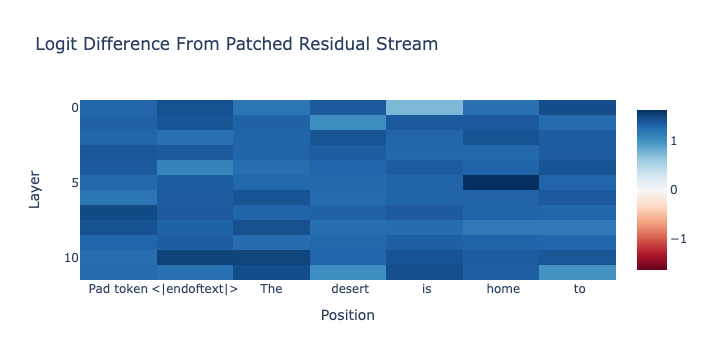

Bill Gates is the founder of


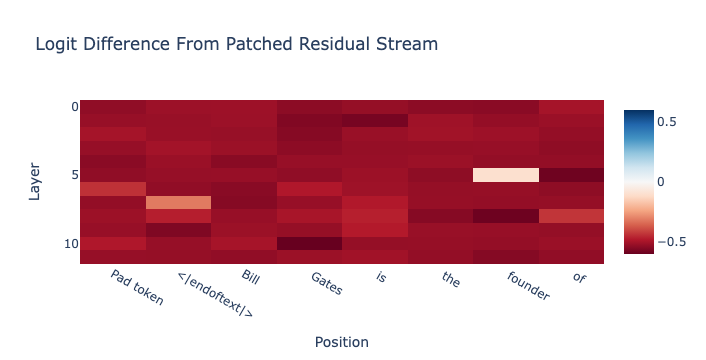

Microsoft was founded by


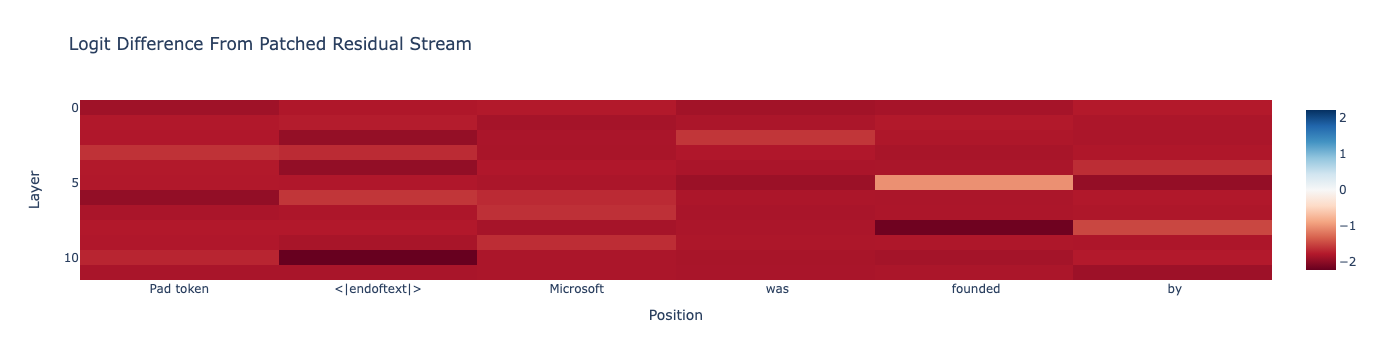

The Nile is the longest river in


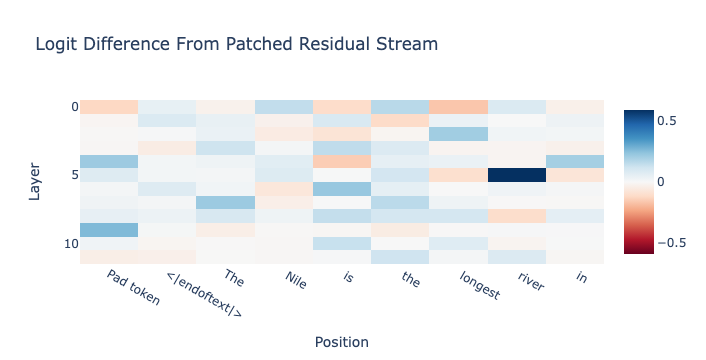

The longest river in Africa is the


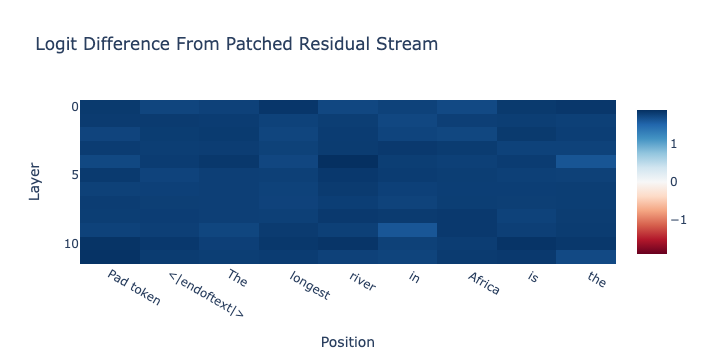

The Yangtze is the longest river in


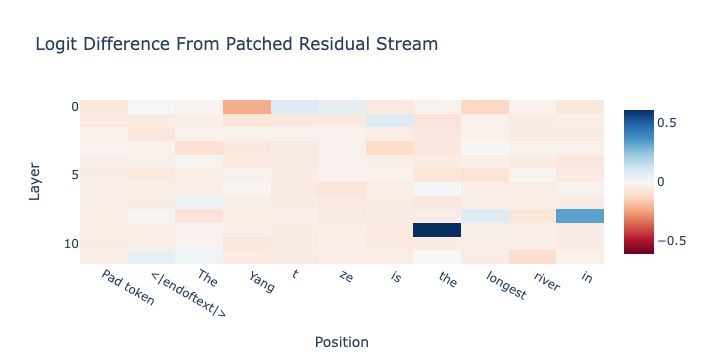

The longest river in Asia is the


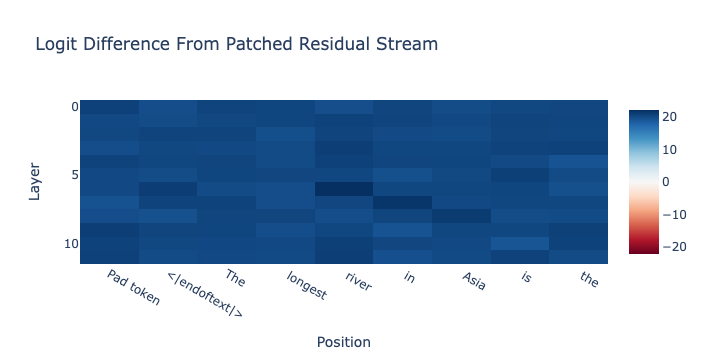

English is the language spoken in


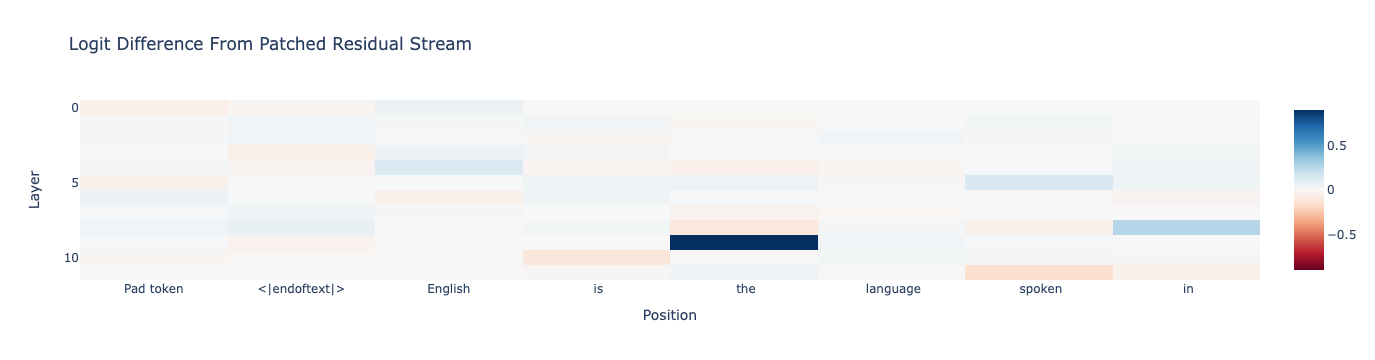

People from England speak


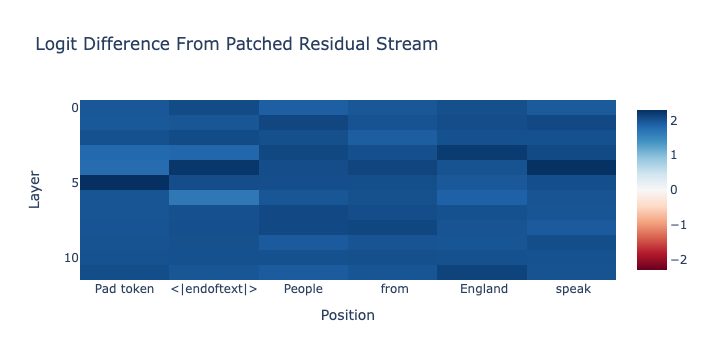

French is the language spoken in


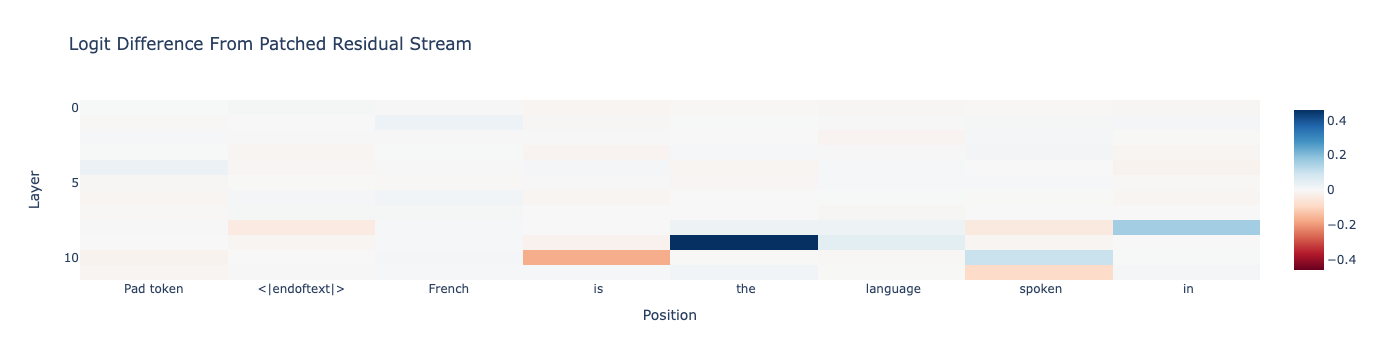

People from France speak


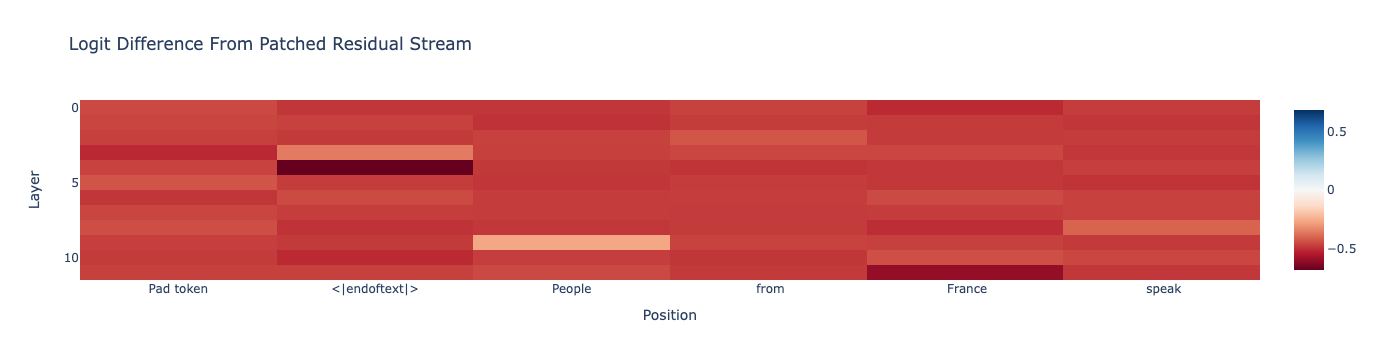

German is the language spoken in


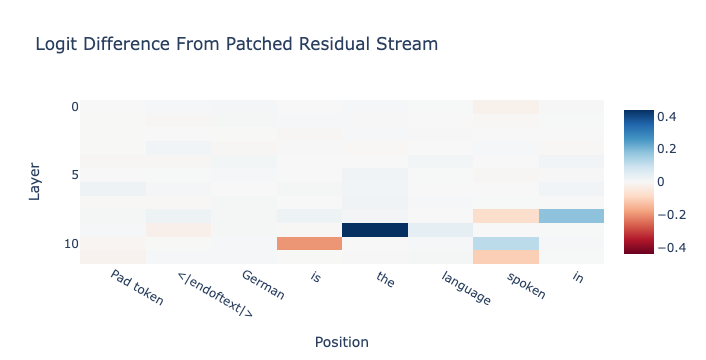

People from Germany speak


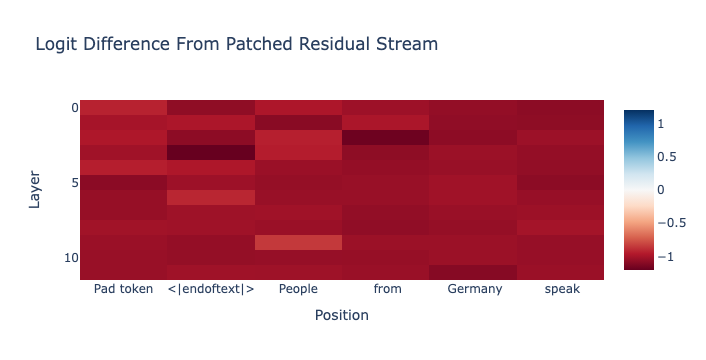

In [466]:

for i,(forward_patch, backward_patch) in enumerate(zip(forward_patches, backward_patches)): 
    prompt = forward_clean_prompts[i]
    print(prompt)
    x = model.to_str_tokens(prompt)
    while len(x) < forward_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(forward_patch,
           x=x,
           title="Logit Difference From Patched Residual Stream", labels={"x":"Position", "y":"Layer"})
    
    prompt = backward_clean_prompts[i]
    print(prompt)
    x = model.to_str_tokens(prompt)
    while len(x) < backward_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(backward_patch,
           x=x,
           title="Logit Difference From Patched Residual Stream", labels={"x":"Position", "y":"Layer"})